In [1]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
import warnings;
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL);
from statsmodels.tools.eval_measures import rmse, rmspe;
from sklearn.metrics import mean_absolute_percentage_error as mape;
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf;
from itertools import product;
from pathlib import Path;

warnings.filterwarnings('ignore');
plt.rcParams['figure.figsize'] = [18,8]

In [2]:
df = pd.read_csv('./assets/data/censo_estadual_2007_a_2022.csv', encoding='latin-1', sep=',', low_memory=False)
df.drop(columns='Unnamed: 0', inplace=True)
df['NU_ANO_CENSO'] = pd.to_datetime(df['NU_ANO_CENSO'], format='%Y').dt.date
df.head(1)

,NU_ANO_CENSO,NO_REGIAO,CO_REGIAO,NO_UF,SG_UF,CO_UF,NO_MUNICIPIO,CO_MUNICIPIO,NO_MESORREGIAO,CO_MESORREGIAO,...,IN_FORMA_CONT_PRESTACAO_SERV,IN_FORMA_CONT_COOP_TEC_FIN,IN_FORMA_CONT_CONSORCIO_PUB,IN_TIPO_ATEND_ESCOLARIZACAO,IN_TIPO_ATEND_AC,IN_TIPO_ATEND_AEE,IN_LABORATORIO_EDUC_PROF,IN_SALA_OFICINAS_EDUC_PROF,IN_MATERIAL_PED_PROFISSIONAL,IN_ESCOLARIZACAO
0,2007-01-01,Nordeste,2,Paraíba,PB,25,Água Branca,2500106,Sertão Paraibano,2501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
matriculas_medio = df.groupby('NU_ANO_CENSO')[['QT_MAT_MED']].sum()
matriculas_profissinal = df.groupby('NU_ANO_CENSO')[['QT_MAT_PROF']].sum()
matriculas_eja = df.groupby('NU_ANO_CENSO')[['QT_MAT_EJA']].sum()

In [13]:
matriculas_profissinal

,QT_MAT_PROF
NU_ANO_CENSO,
2007-01-01,11250.0
2008-01-01,11715.0
2009-01-01,9414.0
2010-01-01,7753.0
2011-01-01,7304.0
2012-01-01,10716.0
2013-01-01,10430.0
2014-01-01,12813.0
2015-01-01,8018.0


<Axes: title={'center': 'Matrículas no Ensino Profissional'}, xlabel='NU_ANO_CENSO'>

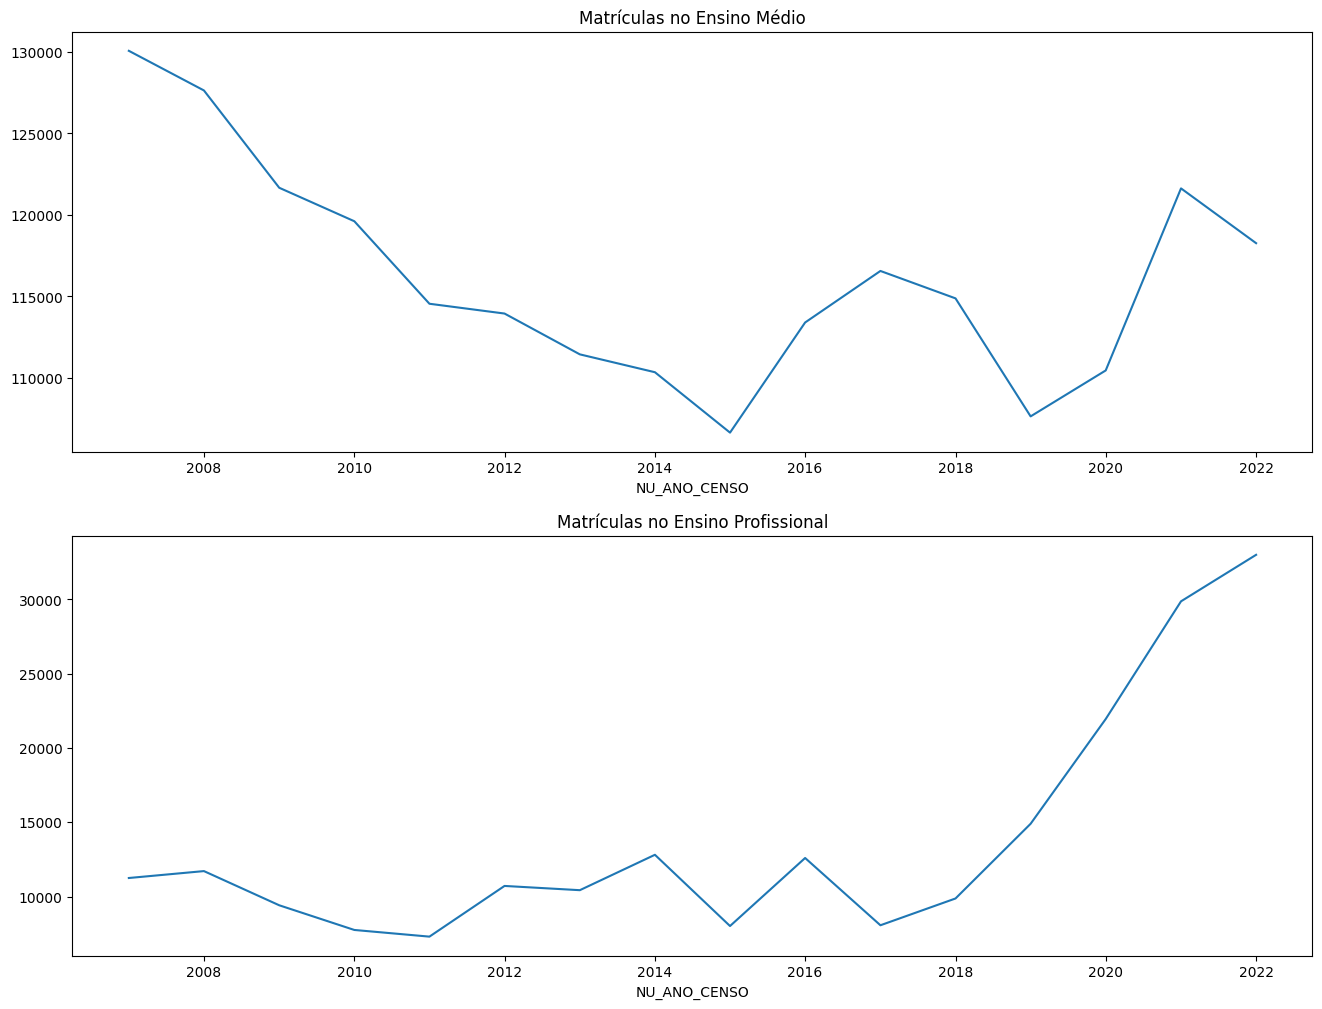

In [14]:
fig, ax = plt.subplots(2,1, figsize=(16,12))
matriculas_medio.plot(title='Matrículas no Ensino Médio', legend=False, ax=ax[0])
matriculas_profissinal.plot(title='Matrículas no Ensino Profissional', legend=False, ax=ax[1])

In [16]:
def split_data(data, test_split):
    l = len(data);
    t_idx = round(l * (1 - test_split));
    train, test = data [ : t_idx ], data[t_idx: ];
    print(f'treino: {len(train)}, Teste: {len(test)}');
    return train, test;

In [19]:
test_split = 0.50;
matriculas_profissinal_train, matriculas_profissinal_test = split_data ( matriculas_profissinal, test_split);
matriculas_medio_train, matriculas_medio_test = split_data ( matriculas_medio, test_split);

treino: 8, Teste: 8
treino: 8, Teste: 8


In [20]:
def check_stationarity(df):
    results = adfuller(df)[1:3];
    s = 'Não Estacionaria';
    if results[0] < 0.05:
        s = 'Estacionaria';
    print(f"'{s}\t p-valor: {results[0]}\t lags: {results[1]}'");
    return (s, results[0]);

In [21]:
def get_best_model(score, c='AIC'):
    initial_score = score[0][c];
    best_model = 0;
    for k, v in score.items():
        if v[c] < initial_score:
            initial_score = v[c];
            best_model = k;
    print(f'Melhor modelo é: {best_model} com menor {c} score: {initial_score}');
    return score[best_model]['model']

In [22]:
def plot_forecast ( model , start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), index=test.index);
    ax = train.loc[start: ].plot(style = '--');
    test.plot(ax = ax);
    forecast.plot(ax=ax, style='-.')
    ax.legend(['orig_train', 'orig_test', 'forecast']);
    plt.show();

In [23]:
def combinator(items):
    combo = [i for i in product(*items)];
    return combo;

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 12 must be < 7.

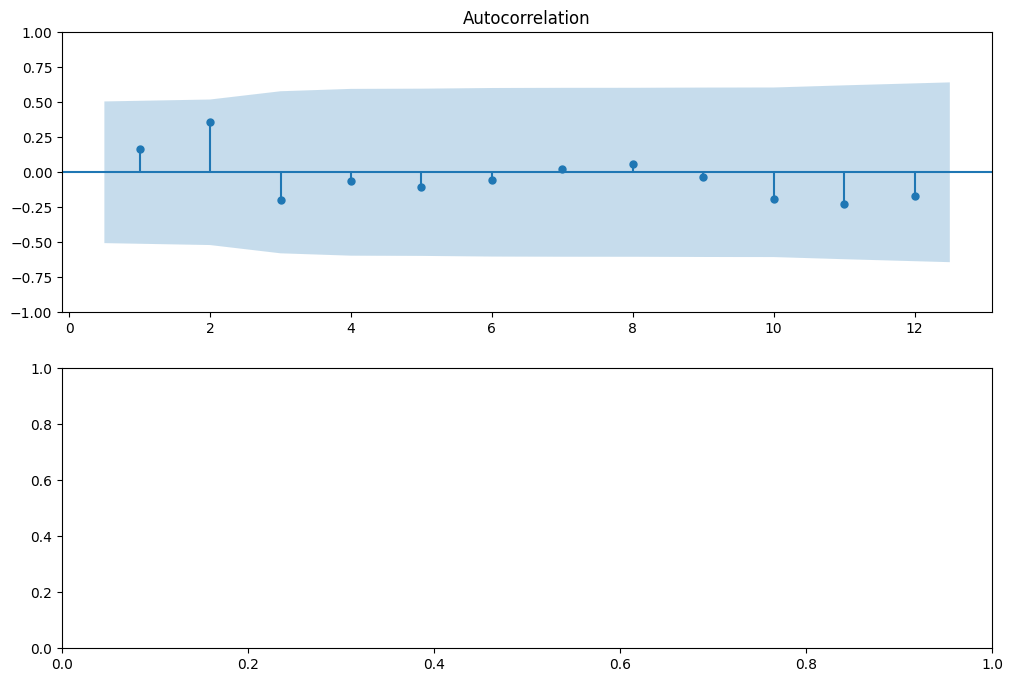

In [24]:
matriculas_profissinal_diff = matriculas_profissinal.diff().dropna()
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(matriculas_profissinal_diff, zero=False, ax=ax[0])
plot_pacf(matriculas_profissinal_diff, zero=False, ax=ax[0])
plt.show()

In [25]:
from statsmodels.tsa.api import ExponentialSmoothing;

In [26]:
trend = ['add', 'mul'];
damped = [True, False];
matriculas_profissinal_ex_comb = combinator([trend, damped])
matriculas_profissinal_ex_comb

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [27]:
train = matriculas_profissinal_train.values.ravel();
y = matriculas_profissinal_test.values.ravel();
score = {};
for i, (t, dp) in enumerate(matriculas_profissinal_ex_comb):
    exp = ExponentialSmoothing(train, 
                                trend=t, 
                                damped_trend = dp,
                                seasonal = None,
                            )
    model = exp.fit(use_brute = True, optimized=True);
    y_hat = model.forecast(len(y));
    score[i] = {
        'trend': t,
        'damped': dp,
        'AIC' : model.aic,
        'BIC' : model.bic,
        'AICc' : model.aicc,
        'RMSPE' :rmspe(y, y_hat),
        'RMSE' : rmse(y, y_hat),
        'MAPE' : mape(y, y_hat),
        'model' : model
    }
    

In [28]:
life_best_model = get_best_model(score, 'AIC');

Melhor modelo é: 1 com menor AIC score: 127.81549132838042


In [29]:

life_best_model.summary()

Dep. Variable:,endog,No. Observations:,8
Model:,ExponentialSmoothing,SSE,25555879.300
Optimized:,True,AIC,127.815
Trend:,Additive,BIC,128.133
Seasonal:,None,AICC,211.815
Seasonal Periods:,None,Date:,"Tue, 12 Dec 2023"
Box-Cox:,False,Time:,09:53:07
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9954999,alpha,True
smoothing_trend,9.0156e-05,beta,True


In [36]:
matriculas_profissinal_test.index[0]

datetime.date(2015, 1, 1)

In [ ]:
plot_forecast(life_best_model, '2008', matriculas_profissinal_train, matriculas_profissinal_test);

: 